# Notebook for make profiling of di-f Correlation experiments

## Experiment name: mxretailsalary1

## Team roles:
* PipeMaster: jag.pascoe
* BizEngineer: 
* DataEngineer:
* MLEngineer:
* SWEngineer:

## Description (Use case):
Predict salary per day estimation to be obtained for working in retail sector in any state of Mexico.
Supposing you are looking for being hired in a Retail Business in any of Mexico's state you want to. You want to predict which would be the base salary per day you might get as attendant of that retail business. This salary not include any commision, tax, or any other concept.

## Type of experiment: Correlation
## Independent Variables (inputs):
1) State of Mexico where you are supposing to get hired (CAT). 
2) How many employees (including yourself) work in that particular business now (NUMBER)
3) How much sales per day in average, you estimate you will provide to that business in pesos (FLOAT)

## Dependent Variables (outputs):
1) Estimated base salary per day (FLOAT)

In [213]:
%load_ext autoreload
%autoreload 2
# The %load_ext autoreload and %autoreload 2 magic commands are used to automatically 
# reload modules when they are changed. This can be useful when you are developing code 
# in an interactive environment, as it allows you to see the changes you make to your modules 
# without having to restart the kernel.
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

# for global initialization: NOT RECOMMENDED
#initialize(version_base=None, config_path="../src/conf")
#compose(config_name='config')

with initialize(version_base=None, config_path="../src/conf"):
    cfg = compose(config_name='config')
    print(cfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'general_ml': {'seed': 123, 'encoding': 'iso-8859-1', 'cloud': 'AWS'}, 'paths': {'project_dir': '...', 'raw_data': '${hydra:runtime.cwd}/data/raw', 'interim_data': '${hydra:runtime.cwd}/data/interim', 'processed_data': '${hydra:runtime.cwd}/data/processed', 'reports': '${hydra:runtime.cwd}/reports'}, 'cloud_paths': {'bucket_path': 'dif-b-democlient-sklearn', 'experiment_path': '${cloud_paths.bucket_path}/mxretailsalary1', 'mlflow_path': '${cloud_paths.experiment_path}/mlflow', 'reports_path': '${cloud_paths.experiment_path}/reports', 'rawdata_path': '${cloud_paths.experiment_path}/raw-data', 'dvc_path': '${cloud_paths.experiment_path}/dvc-store'}, 'file_names': {'raw_file': 'raw-data.csv', 'data_file': 'datafile.csv', 'train_features': 'train_features.csv', 'train_labels': 'train_labels.csv', 'validation_features': 'valid_features.csv', 'validation_labels': 'valid_labels.csv', 'test_features': 'tes

In [214]:
import pandas as pd
import numpy as np
import ydata_profiling as yp
import os

In [215]:
#reading raw-data

raw_file = pd.read_csv(os.path.join('../data/raw', cfg.file_names.raw_file), 
                   #encoding=cfg.general_ml.encoding,
                   )
raw_file.head()

,state,municipio,businesses,employees,payroll,expenditures,income,payroll_employee_day,profits_biz_day,sales_employee_day,employees_unit
0,Ags,Aguascalientes,11402,120923,4997.813674,129044.643300,159695.334000,114.807074,6249.604612,3668.434872,10.6054201
1,Ags,Asientos,231,1647,29.092255,524.807734,621.055144,49.066071,807.5415528,1047.451838,7.12987013
2,Ags,Calvillo,591,4605,99.342787,1743.278407,2246.247441,59.924470,1897.09648,1354.956835,7.791878173
3,Ags,Cosio,104,468,4.577495,101.941048,136.364948,27.169366,797.1796419,809.383597,4.5
4,Ags,El Llano,104,860,14.802274,342.630524,427.291666,47.810963,1865.888567,1380.141041,8.269230769


In [216]:
#cutting dataset for this experiment
data=raw_file[['state',
        'businesses',
        'employees',
        'payroll',
        'income']]
data

,state,businesses,employees,payroll,income
0,Ags,11402,120923,4997.813674,159695.334000
1,Ags,231,1647,29.092255,621.055144
2,Ags,591,4605,99.342787,2246.247441
3,Ags,104,468,4.577495,136.364948
4,Ags,104,860,14.802274,427.291666
...,...,...,...,...,...
2482,Zacatecas,147,785,2.811121,160.114046
2483,Zacatecas,149,875,4.875017,289.174975
2484,Zacatecas,96,604,7.800028,219.851736
2485,Zacatecas,339,2043,34.189010,1282.438977


In [217]:
#reviewing data types
data.dtypes

state          object
businesses      int64
employees       int64
payroll       float64
income        float64
dtype: object

In [218]:
# Finding number of records with 0, NaN, or empty values
mask=data.apply(lambda x: any([val == 0 or pd.isna(val) or val == '' for val in x]), axis=1)
mask.sum()



294

In [219]:
#finding recosrds with nan 
data.isna().sum()

state           0
businesses      0
employees       0
payroll       291
income          0
dtype: int64

In [220]:
#correcting nan in Payroll by substitute them with the payrrol mean by estado.


# Compute the average by category
payroll_average = data.groupby('state')['payroll'].transform('mean')
employees_average = data.groupby('state')['employees'].transform('mean')


# Replace NaN values with the corresponding category average
payroll2 = data['payroll'].fillna(data['employees']*payroll_average/employees_average)
data['payroll']=payroll2

# Display the modified dataframe
print(data[mask])


          state  businesses  employees    payroll     income
39      Chiapas          13         79   1.483476   8.962597
42      Chiapas         115        431   8.093396  58.165424
53      Chiapas          35        206   3.868305   7.446105
55      Chiapas         117       1273  23.904624  28.164835
118     Chiapas          52        320   6.009018  24.373607
...         ...         ...        ...        ...        ...
2339    Yucatan          39        216   5.914762  15.669369
2381    Yucatan          13         57   1.560840   6.120514
2394    Yucatan          35        240   6.571958  23.735218
2415    Yucatan          34        199   5.449249  19.897894
2437  Zacatecas           8         51   1.320541   5.280897

[294 rows x 5 columns]


In [221]:
# check records with zeros
data[data['employees']==0]
data[data['businesses']==0]

,state,businesses,employees,payroll,income
1124,Oaxaca,0,4,0.162169,0.228270
1128,Oaxaca,0,2,0.081084,2.125273
1157,Oaxaca,0,12,0.486506,1.361749
1179,Oaxaca,0,8,0.324337,1.424720
1323,Oaxaca,0,8,0.324337,0.401441
1843,SLP,0,8,0.070601,1.082082
1868,SLP,0,6,0.094135,3.236613
2010,Tamaulipas,0,42,0.134895,8.080339
2039,Tamaulipas,0,3,0.126318,0.999211


In [222]:
# Replace cero values with other value
data.loc[data['businesses'] == 0, 'businesses'] = 1.0
data.head()


,state,businesses,employees,payroll,income
0,Ags,11402,120923,4997.813674,159695.334000
1,Ags,231,1647,29.092255,621.055144
2,Ags,591,4605,99.342787,2246.247441
3,Ags,104,468,4.577495,136.364948
4,Ags,104,860,14.802274,427.291666


In [223]:
# create new fields 

data['income_employee_day']=data['income']*1000000/data['employees']/360
data['employees_business'] = (data['employees']/data['businesses']+0.5).astype(int)
data['salary_employee_day']=data['payroll']*1000000/data['employees']/360

#droping innecesary fields
data=data.drop(['employees', 'income','businesses','payroll'],axis=1)

# correcting data types and renaming the fields to be more accurate
data['state']=data['state'].astype('category')

data.head()

,state,income_employee_day,employees_business,salary_employee_day
0,Ags,3668.434872,11,114.807074
1,Ags,1047.451838,7,49.066071
2,Ags,1354.956835,8,59.924470
3,Ags,809.383597,5,27.169366
4,Ags,1380.141041,8,47.810963


In [225]:
#running the profiler to review data

ProfileReport = yp.ProfileReport(data, title=str(cfg.file_names.data_profiling_report), explorative=True)
ProfileReport.to_file(os.path.join('../reports', cfg.file_names.data_profiling_report), 
                      #encoding=cfg.general_ml.encoding
                     )

ProfileReport

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [226]:
    
#Choose the Ml model to be applied, among: regression, Classifications, time_series, Clustering, NLP
from pycaret.regression import *

In [58]:
#to show docstring of setup() function
?setup

Signature:
setup(
    data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None,
    data_func: Optional[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]]] = None,
    target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1,
    index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True,
    train_size: float = 0.7,
    test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None,
    ordinal_features: Optional[Dict[str, list]] = None,
    numeric_features: Optional[List[str]] = None,
    categorical_features: Optional[List[str]] = None,
    date_features: Optional[List[str]] = None,
    text_features: Optional[List[str]] = None,
    ignore_features: Optional[List[str]] = None,
    keep_features: Optional[List[str]] = None,
    preprocess: 

In [239]:
model_to_find =   setup(data = data, #see above 
                        #log_experiment = True,
                        #experiment_name = f'{cfg.general_ml.client}-{cfg.general_ml.project}-{cfg.general_ml.experiment}',
                        #target = cfg.data_fields.label, # get the target label from cfg
                        target='salary_employee_day',
                        train_size=0.75, #default = 0.7
                        #session_id=cfg.general_ml.seed, # get the seed from config
                        #train_size = 1.0-float(cfg.data_pipeline.data_transform_params.percent_valid), #get %valid from cfg
                        transformation=True, 
                        #fix_imbalance = True, #8:2
                        normalize=True,
                        #normalize_method="minmax",
                        #polynomial_features=True,
                        #polynomial_degree = 4,
                        max_encoding_ohe =32, #default=25,
                        remove_multicollinearity=True,
                        remove_outliers=True,
                        categorical_features=['state']
                        #outliers_threshold=0.075, #default=0.05
                        )

,Description,Value
0,Session id,8203
1,Target,salary_employee_day
2,Target type,Regression
3,Original data shape,"(2487, 4)"
4,Transformed data shape,"(2393, 4)"
5,Transformed train set shape,"(1771, 4)"
6,Transformed test set shape,"(622, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [241]:
get_config('X_transformed')

,state,income_employee_day,employees_business
2328,-1.640532,-0.434418,0.470288
2081,-0.347259,-1.413840,-0.997644
1365,1.206956,-1.453310,-0.997644
762,-1.103601,0.179074,-0.182019
1216,1.206956,-0.167007,-2.065082
...,...,...,...
1350,1.206956,-0.635101,-0.182019
1868,0.037109,0.813879,0.470288
1275,1.206956,-1.668646,-0.182019
2465,-0.369128,-0.979194,0.470288


In [242]:
best_model=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,21.9442,1007.8107,31.6256,0.4332,0.9974,3.2574,1.4140
catboost,CatBoost Regressor,21.0824,1022.7752,31.8616,0.4263,0.9864,3.1739,1.4170
lightgbm,Light Gradient Boosting Machine,21.5622,1073.3733,32.6219,0.4004,1.0092,3.3421,0.4340
rf,Random Forest Regressor,22.1842,1156.6210,33.9129,0.3503,1.0138,3.2674,1.0640
knn,K Neighbors Regressor,22.5987,1173.6809,34.1093,0.3437,1.0175,3.2869,0.4280
xgboost,Extreme Gradient Boosting,22.1262,1186.0799,34.3546,0.3305,1.0327,3.2570,0.6000
et,Extra Trees Regressor,22.7480,1326.9403,36.3790,0.2500,1.0677,3.3603,1.2910
lr,Linear Regression,27.4641,1370.4684,36.9324,0.2308,1.0690,2.9641,0.9240
ridge,Ridge Regression,27.4650,1370.4928,36.9327,0.2308,1.0690,2.9643,0.3900
lar,Least Angle Regression,27.4641,1370.4684,36.9324,0.2308,1.0690,2.9641,0.4210


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [62]:
# And create the selected model in ten kfolds

selected_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.2547,734.1539,27.0953,0.4390,0.6284,0.8763
1,10.3954,228.5378,15.1175,0.7971,0.5263,0.6839
2,9.7606,190.1407,13.7892,0.8028,0.4902,0.6861
3,13.0594,495.9578,22.2701,0.6288,0.6219,0.8458
4,20.3301,4386.1001,66.2276,0.3287,0.6122,0.8705
5,11.6433,328.8944,18.1354,0.6873,0.5614,1.0372
6,12.5301,402.4117,20.0602,0.7136,0.5125,0.8470
7,14.0588,765.1270,27.6609,0.5827,0.5413,0.6690
8,13.5969,534.0057,23.1086,0.6087,0.5742,0.6863


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
# Now lets find the best hyperparameters for the selected model 

tuned_model = tune_model(selected_model)



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.8486,770.1632,27.7518,0.4115,0.6511,0.8314
1,10.5145,212.8042,14.5878,0.8111,0.6872,0.7916
2,11.0200,224.6874,14.9896,0.7669,0.6933,1.0197
3,13.0413,505.1106,22.4747,0.6220,0.7022,0.9993
4,19.1793,3915.2571,62.5720,0.4008,0.6313,0.8997
5,11.9155,293.5836,17.1343,0.7209,0.7234,1.7272
6,11.8037,366.4819,19.1437,0.7392,0.6378,1.0849
7,14.3465,708.3599,26.6150,0.6136,0.5962,0.7945
8,13.8313,518.1040,22.7619,0.6203,0.5903,0.6280


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


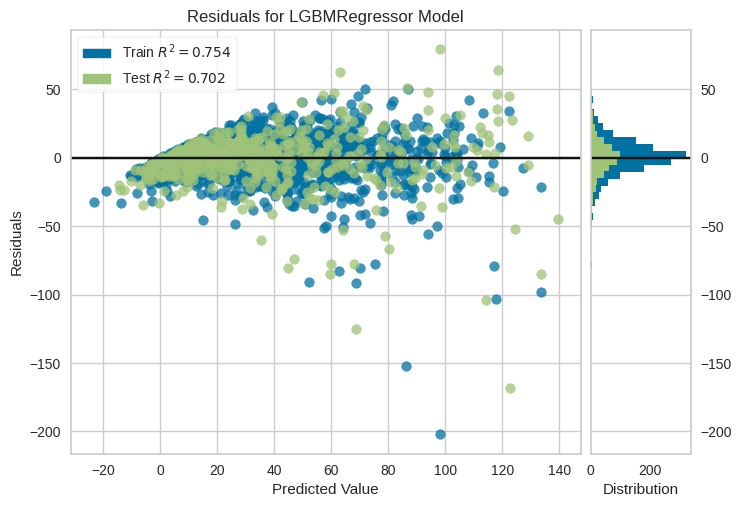

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [64]:
# and .. evaluate the model

plot_model(tuned_model)
evaluate_model(tuned_model)



In [65]:
# Finally trains a the model on the entire dataset including the hold-out set.

final_model = finalize_model(tuned_model)
final_model




Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['income_employee_day',
                                             'employees_business'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['estado'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('rest_encoding',
                 TransformerWrapper(include=['estado'],
                                    t...
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 LGBMRegressor(bagging_fraction=0.7, bagging_freq=3,
                               feature_fraction=0.4, learning_rate=0.5,
                               min_child_samples=6, min_split_gain=0.5,
                               n_estimators=60, num_leaves=8, random_state=3079,
                               reg_alpha=0.001, reg_lambda=2))])

In [66]:
get_config('X_transformed')

,estado,employees_business,estado income_employee_day
404,-1.315719,-1.138752,-0.916912
855,0.735164,-1.138752,-0.611001
469,1.471395,-0.276023,1.507741
1688,-0.887650,-1.138752,-0.075457
1762,-0.887650,-0.276023,-1.255923
...,...,...,...
201,0.620919,0.391793,0.546097
831,0.735164,0.391793,0.443965
2371,-1.890701,2.590934,0.898168
486,1.471395,0.391793,1.545110


In [67]:
# save the model

#save_model(final_model, os.path.join(cfg.paths.models, cfg.file_names.ml_profiling_model))
